In [1]:
# !nvidia-smi

In [2]:
# import os
# !pip install -q fastai2 fastcore torch feather-format kornia pyarrow wandb nbdev fastprogress --upgrade 
# !pip install torchvision==0.4.2
# !pip install Pillow==6.2.1 --upgrade
# os._exit(00)

In [3]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = Path('/content/gdrive/My Drive/')
root_dir = Path('.')

In [5]:
# !gdown "https://drive.google.com/uc?id=1ffJr3NrYPqzutcXsYIVNLXzzUaC9RqYM"

In [6]:
# import zipfile
# with zipfile.ZipFile('cat-dataset.zip', 'r') as zip_ref: zip_ref.extractall()

In [10]:
# source = Path('cats')
source = Path('/home/lgvaz/.data/cats')
fns = get_image_files(source)

In [11]:
def get_y_fn(fn): return fn.with_suffix(fn.suffix+'.cat')
def get_kpts(fn): return np.genfromtxt(fn)[1:].reshape(-1,2)
def get_y(fn):    return get_kpts(get_y_fn(fn))

In [12]:
# Remove cropped cats
# fns = L(fn for fn in progress_bar(fns_original) if (np.array(PILImage.create(fn).size)>get_y(fn)).all() and (get_y(fn)>=0).all())
# len(fns_original) - len(fns)

In [13]:
splits = RandomSplitter(seed=42, valid_pct=0.1)(fns); splits
# splits = (L(range(len(fns))), ()); splits

((#8998) [1303,8607,6679,4255,4697,3769,1697,8715,7247,3845...],
 (#999) [278,5064,9538,9403,2293,8476,4803,7941,2871,7678...])

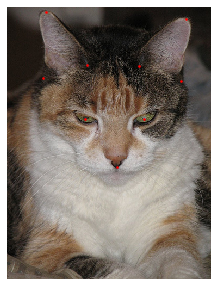

In [14]:
dset = Datasets(fns, tfms=[[PILImage.create], [get_y_fn, get_kpts, TensorPoint.create]], splits=splits)
dset.show(dset[42])

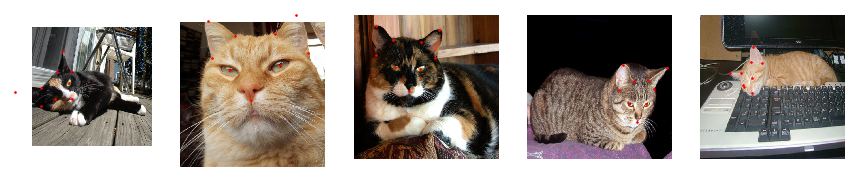

In [15]:
# If I put ToTensor() on Datasets it doesn't work, why?
after_item = [ToTensor(), PointScaler(), Resize(512, method='squish')]
after_batch = [IntToFloatTensor(), *aug_transforms(), Normalize.from_stats(*imagenet_stats)]
dl = dset.dataloaders(bs=64, after_item=after_item, after_batch=after_batch)
dl.show_batch(max_n=5, rows=1)

In [18]:
learn = torch.load('stage2')

In [20]:
learn = cnn_learner(dl, resnet34, y_range=(-1.5, 1.5),
                    loss_func=L1LossFlat(), opt_func=ranger, metrics=[MSELossFlat()])

In [21]:
learn.load('stage2')

In [0]:
# learn.path = root_dir/'dl/cat_kpts'

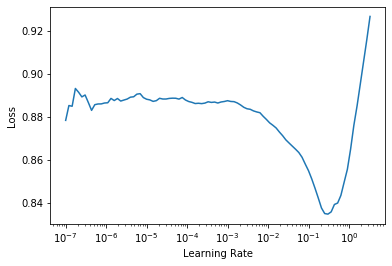

In [0]:
learn.lr_find()

In [0]:
# 0.092, 0.055
learn.fit_flat_cos(5, 1e-1)

epoch,train_loss,valid_loss,None,time
0,0.362292,0.275782,0.136304,03:14
1,0.290401,0.249745,0.103661,03:07
2,0.289733,0.265253,0.120287,03:17
3,0.282515,0.299972,0.160964,03:16
4,0.250237,0.227288,0.092825,03:20


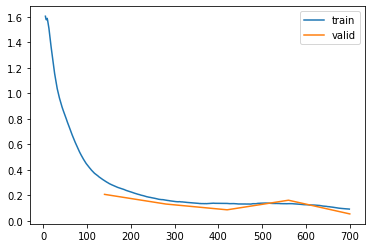

In [0]:
learn.recorder.plot_loss()

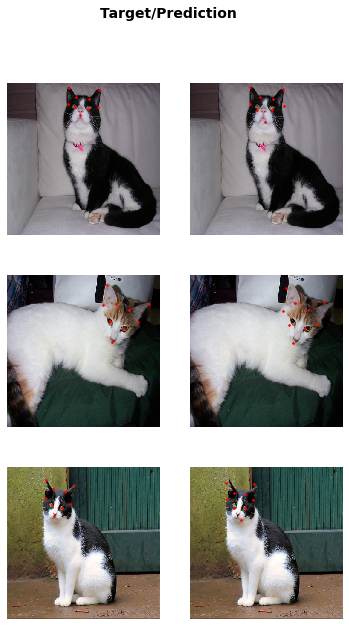

In [0]:
learn.show_results()

In [0]:
learn.save('stage1')

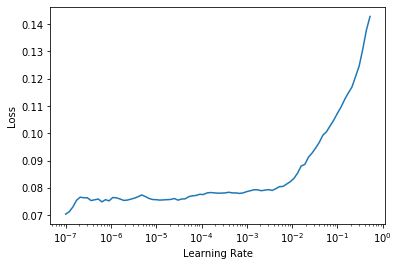

In [0]:
learn.unfreeze()
learn.lr_find()

In [0]:
# 0.06, 0.04
learn.fit_flat_cos(5, slice(1e-3, 1e-5))

epoch,train_loss,valid_loss,None,time
0,0.075711,0.051874,0.007648,03:37
1,0.073352,0.057327,0.008040,03:38
2,0.070641,0.045571,0.005519,03:38
3,0.069197,0.043717,0.005213,03:40
4,0.066675,0.040132,0.004476,03:39


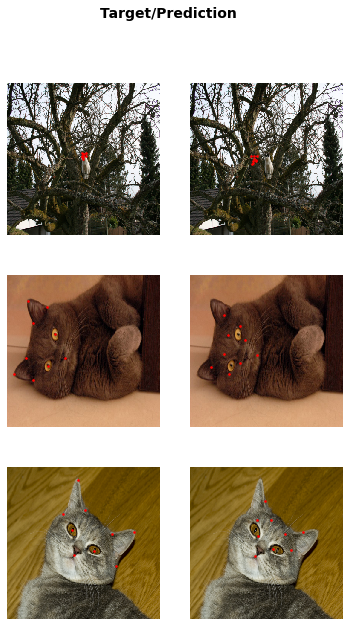

In [23]:
learn.show_results()

In [0]:
learn.save('stage2')

In [27]:
im,pt = dset[42]

In [29]:
pred,_,_ = learn.predict(im)

In [31]:
learn.show_results??

In [34]:
learn.show_results??

In [36]:
dl = learn.dls.test_dl(fns[10:32])
inp,preds,_,dec_preds = learn.get_preds(dl=dl, with_input=True, with_decoded=True)

In [46]:
im.size

(375, 500)

In [52]:
type(im)

fastai2.vision.core.PILImage

In [55]:
type(Resize((512,512),method='squish')(im))

fastai2.vision.core.PILImage

In [51]:
type(im.resize((512,512)))

PIL.Image.Image

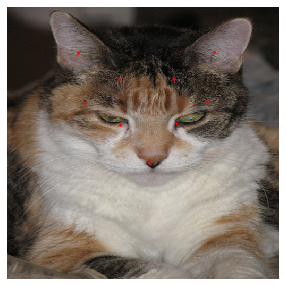

In [56]:
ax = Resize((512,512),method='squish')(im).show()
pred.show(ax)